## Accessing all profiles at once 

Conveniently, all the core mission profiles are compacted in a single file, named: `<FloatWmoID>_prof.nc`. However, some information is only in the individual profile files, but we will see it. 

In [1]:
import numpy as np
import xarray as xr
import netCDF4
from matplotlib import pyplot as plt
%matplotlib inline

In [41]:
prof  = xr.open_dataset('../../Data/202509-ArgoData/dac/coriolis/6903296/6903296_prof.nc')

In [42]:
#prof  = xr.open_dataset('../../Data/6903296/6903296_prof.nc')

Let's visualize all the salinity observations, a first a quick-look 

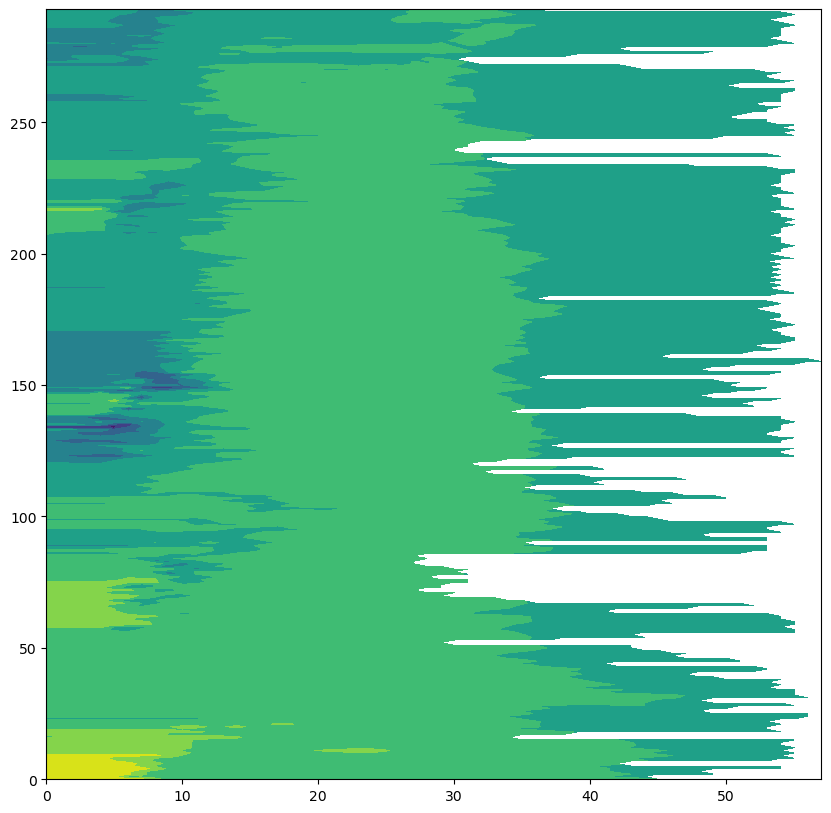

In [43]:
fig , ax = plt.subplots(figsize=(10,10))
ax.contourf(prof.PSAL);

In [44]:
prei=np.arange(5,1005,5) # we define a common set of pressure values:

We define the new *vectors*

In [45]:
juld=prof.JULD.values
psal=prof.PSAL.values
temp=prof.TEMP.values
pres=prof.PRES.values

psali= np.zeros((juld.shape[0],prei.shape[0]))
psali.fill(np.nan)

tempi= np.zeros((juld.shape[0],prei.shape[0]))
tempi.fill(np.nan)

and then we interpolate the salinity and the temperature onto the new levels:

In [46]:
for ip in range(0,pres.shape[0]-1):
    psali[ip,:]=np.interp(prei,pres[ip,:],psal[ip,:])
    tempi[ip,:]=np.interp(prei,pres[ip,:],temp[ip,:])

and let's plot the time evolution of the saliniy measured by this float. in oceanography we usually call it a *section*

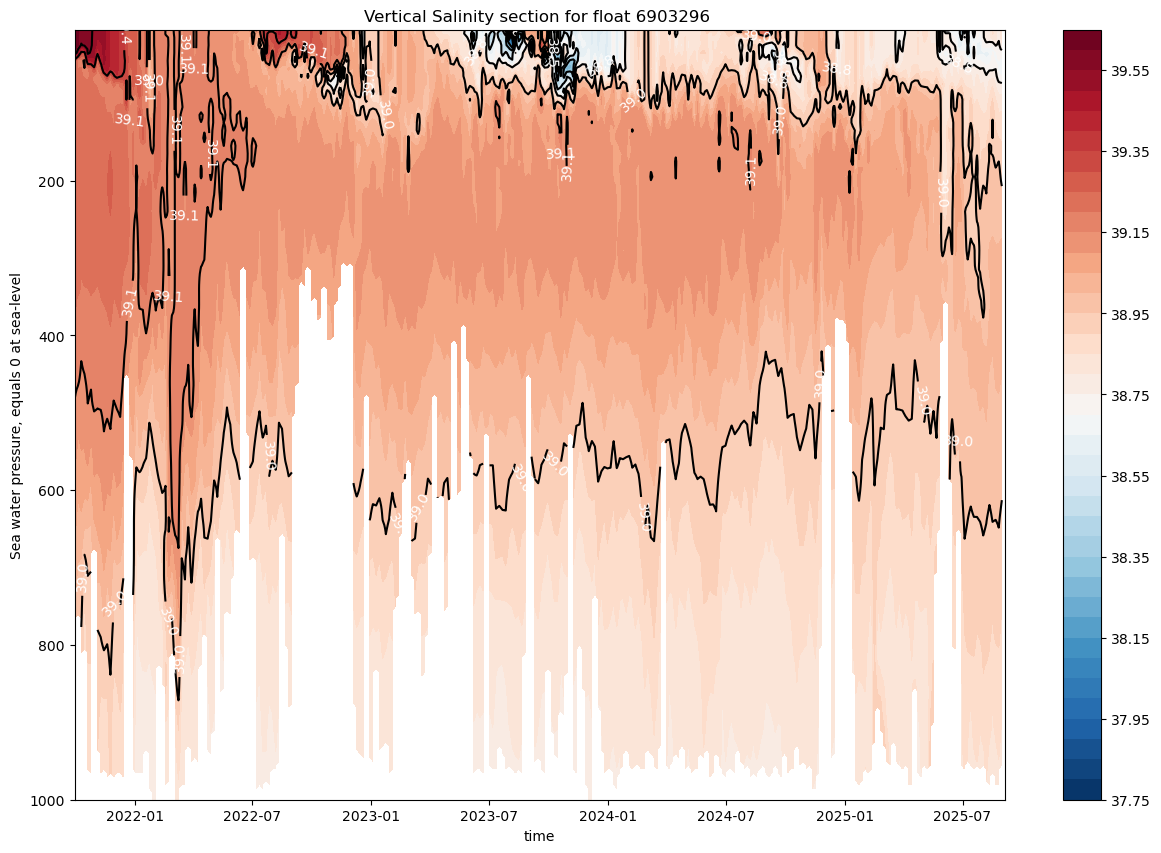

In [47]:
fig, ax = plt.subplots(figsize=(15,10))

#Draw the contours for the salinity
cs=ax.contourf(juld,prei,psali.transpose(),40,cmap="RdBu_r")

#Draw the contours lines to be labelled
cs2=ax.contour(juld,prei,psali.transpose(),colors=('k'), levels=cs.levels[::4])

#Since pressure increase away from the surface we invert the y-axis
ax.invert_yaxis()
ax.clabel(cs2, fmt='%2.1f', colors='w', fontsize=10)

#Add the titles
ax.set_title(f"Vertical Salinity section for float {prof.PLATFORM_NUMBER[0].astype(str).values}")
ax.set_xlabel(f"{prof.JULD.standard_name}")
ax.set_ylabel(f"{prof.PRES.long_name}")

#Add the colorbar
cbar=fig.colorbar(cs,ax=ax)

And the same for temperature:

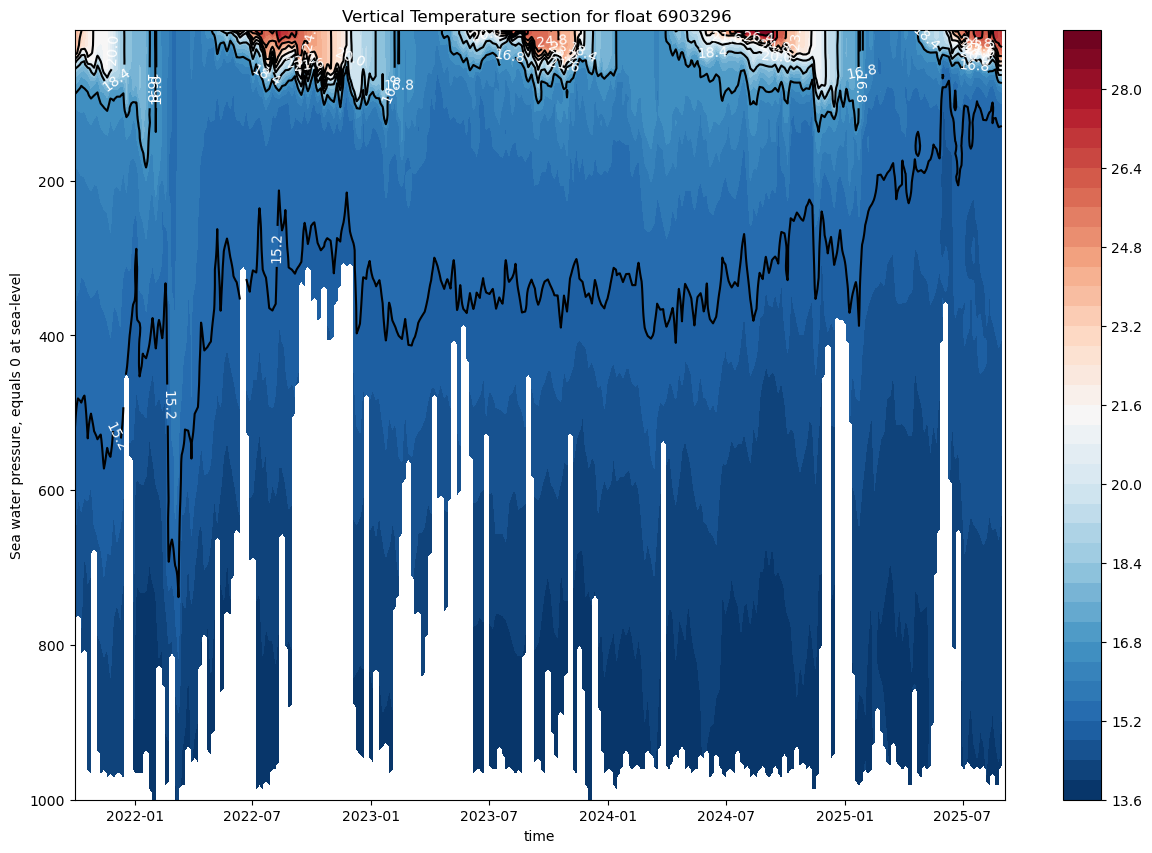

In [48]:
fig, ax = plt.subplots(figsize=(15,10))

cs=ax.contourf(juld,prei,tempi.transpose(),40,cmap="RdBu_r")
cs2=ax.contour(juld,prei,tempi.transpose(),colors=('k'), levels=cs.levels[::4])

ax.invert_yaxis()
ax.clabel(cs2, fmt='%2.1f', colors='w', fontsize=10)

ax.set_title(f"Vertical Temperature section for float {prof.PLATFORM_NUMBER[0].astype(str).values}")
ax.set_xlabel(f"{prof.JULD.standard_name}")
ax.set_ylabel(f"{prof.PRES.long_name}")

cbar=fig.colorbar(cs,ax=ax)

### TS-diagram

In oceanography, temperature-salinity diagrams, sometimes called T-S diagrams, are used to identify water masses. In a **T-S diagram**, rather than plotting plotting temperatute and salinity as a separate "profile," with pressure or depth as the vertical coordinate, potential temperature (on the vertical axis) is plotted versus salinity (on the horizontal axis). 

This diagrams area very useful since as long as it remains isolated from the surface, where heat or fresh water can be gained or lost, and in the absence of mixing with other water masses, a water parcel's potential temperature and salinity are conserved. Deep water masses thus retain their T-S characteristics for long periods of time, and can be identified readily on a T-S plot. 

In this case we add a colobar bar to show the pressure of each data point.


In [49]:
import seawater as sw

In [50]:
#temp=prof.TEMP.values.flatten()
#psal=prof.PSAL.values.flatten()
#pres=prof.PRES.values.flatten()
#ptmp=sw.ptmp(psal, temp, pres, pr=0)

compute potential temperature

In [35]:
temp=prof.TEMP.values
psal=prof.PSAL.values
pres=prof.PRES.values
ptmp= np.zeros((temp.shape[0],temp.shape[1]))

In [36]:
for ip in range(0,temp.shape[0]):
    ptmp[ip,:]=sw.ptmp(psal[ip,:], temp[ip,:], pres[ip,:], pr=0)

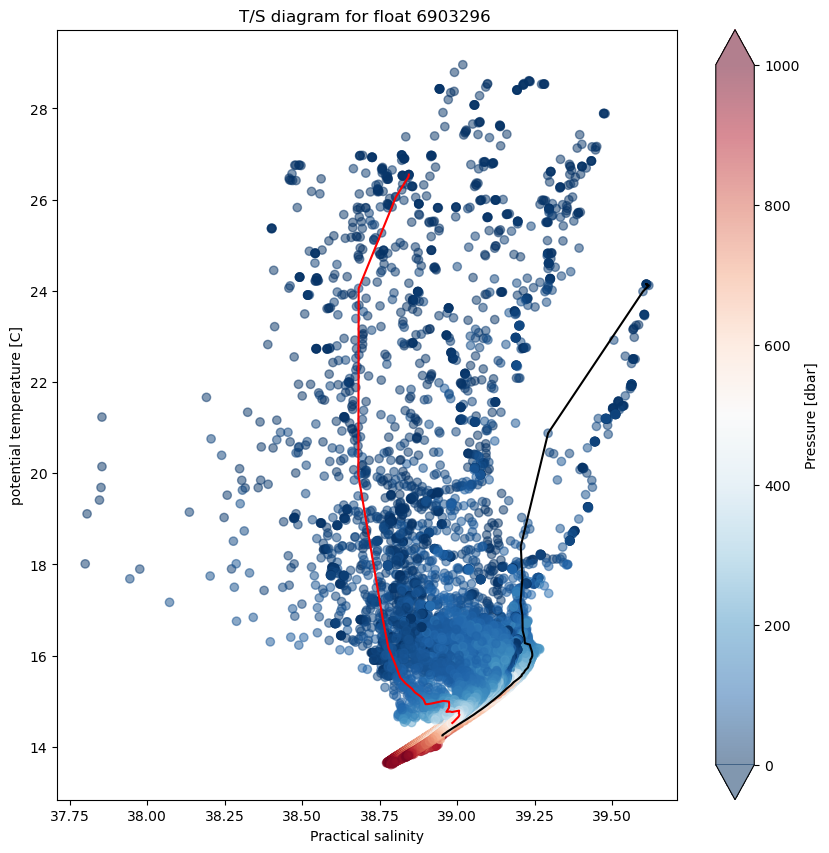

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
sc=ax.scatter(psal, ptmp, c=pres,alpha=0.5, cmap="RdBu_r",vmin=0, vmax=1000)
ax.plot(psal[0,:], ptmp[0,:],'k')
ax.plot(psal[-1,:], ptmp[-1,:],'r')
ax.set_title(f"T/S diagram for float {prof.PLATFORM_NUMBER[0].astype(str).values}")
ax.set_ylabel("potential temperature [C]")
ax.set_xlabel(f"{prof.PSAL.long_name}")
cbar=fig.colorbar(sc,extend='both');
cbar.set_label('Pressure [dbar]')

In [14]:
Rtraj = xr.open_dataset('../../Data/6903296/6903296_Rtraj.nc')

/var/folders/tj/cj2twzcd30jbzn574lsp6phw0000gn/T/ipykernel_34694/4181504582.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  Rtraj = xr.open_dataset('../../Data/6903296/6903296_Rtraj.nc')


In [15]:
import cartopy.crs as ccrs
import cartopy

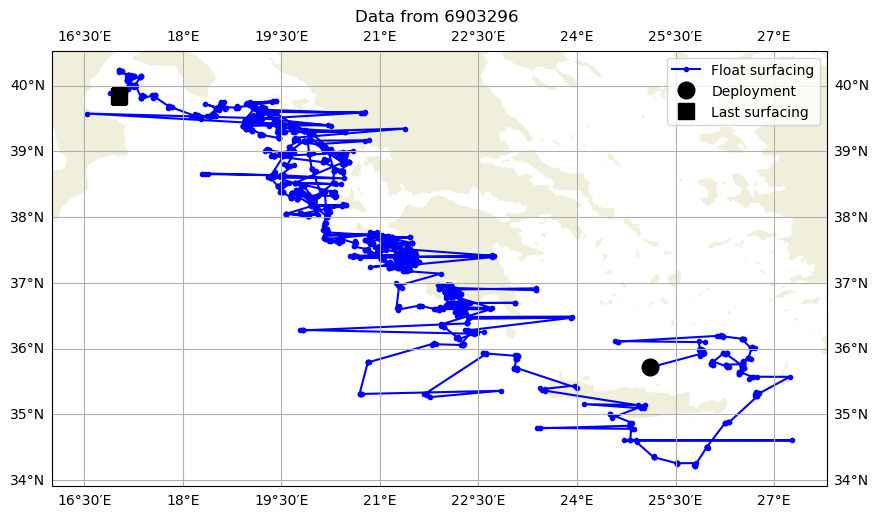

In [16]:
lon=Rtraj.LONGITUDE[~np.isnan(Rtraj.LONGITUDE) & ~np.isnan(Rtraj.LATITUDE)]
lat=Rtraj.LATITUDE[~np.isnan(Rtraj.LONGITUDE) & ~np.isnan(Rtraj.LATITUDE)]

fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})
ax.plot(lon,lat,'-b.',label='Float surfacing')
ax.plot(lon[0],lat[0],'ok',markersize=12,label='Deployment')
ax.plot(lon[-1],lat[-1],'sk',markersize=12,label='Last surfacing')

ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.COASTLINE, edgecolor='white')
ax.set_title(f"Data from {Rtraj.PLATFORM_NUMBER.values.astype(str)}")
ax.legend()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False);

In [17]:
Rtraj

<xarray.Dataset> Size: 4MB
Dimensions:                              (N_PARAM: 3, N_MEASUREMENT: 17010,
                                          N_CYCLE: 295, N_CALIB_PARAM: 1,
                                          N_CALIB_JULD: 1, N_HISTORY: 150)
Dimensions without coordinates: N_PARAM, N_MEASUREMENT, N_CYCLE, N_CALIB_PARAM,
                                N_CALIB_JULD, N_HISTORY
Data variables: (12/113)
    DATA_TYPE                            object 8B ...
    FORMAT_VERSION                       object 8B ...
    HANDBOOK_VERSION                     object 8B ...
    REFERENCE_DATE_TIME                  object 8B ...
    DATE_CREATION                        object 8B ...
    DATE_UPDATE                          object 8B ...
    ...                                   ...
    HISTORY_PARAMETER                    (N_HISTORY) object 1kB ...
    HISTORY_PREVIOUS_VALUE               (N_HISTORY) float32 600B ...
    HISTORY_INDEX_DIMENSION              (N_HISTORY) object 1kB ...
    HISTORY_START_INDEX                  (N_HISTORY) float64 1kB ...
    HISTORY_STOP_INDEX                   (N_HISTORY) float64 1kB ...
    HISTORY_QCTEST                       (N_HISTORY) object 1kB ...
Attributes:
    title:                        Argo float trajectory file
    institution:                  CORIOLIS
    source:                       Argo float
    history:                      2025-01-20T13:56:03Z creation; 2025-09-09T0...
    references:                   http://www.argodatamgt.org/Documentation
    user_manual_version:          3.4
    Conventions:                  Argo-3.2 CF-1.6
    featureType:                  trajectory
    decoder_version:              CODA_079a
    id:                           https://doi.org/10.17882/42182
    comment_on_resolution:        JULD and PRES variable resolutions depend o...
    comment_on_measurement_code:  Meaning of some specific measurement codes ...

In [18]:
lon=Rtraj.LONGITUDE.where(Rtraj.POSITION_QC.values.astype(float) == 1)
lat=Rtraj.LATITUDE.where(Rtraj.POSITION_QC.values.astype(float) == 1)

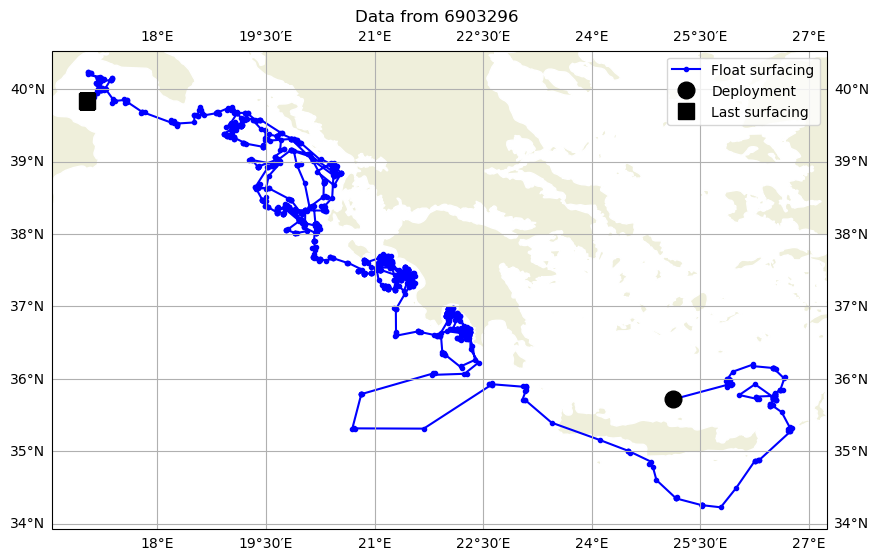

In [19]:
lon=lon[~np.isnan(lon) & ~np.isnan(Rtraj.LATITUDE)]
lat=lat[~np.isnan(lat) & ~np.isnan(Rtraj.LATITUDE)]

fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})
ax.plot(lon,lat,'-b.',label='Float surfacing')
ax.plot(lon[0],lat[0],'ok',markersize=12,label='Deployment')
ax.plot(lon[-1],lat[-1],'sk',markersize=12,label='Last surfacing')

ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.COASTLINE, edgecolor='white')
ax.set_title(f"Data from {Rtraj.PLATFORM_NUMBER.values.astype(str)}")
ax.legend()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False);